### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = '0.1%B.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

In [3]:
print(centroids)

[[   0    9]
 [   0  120]
 [   0 1244]
 [   0   25]
 [   0   63]
 [   0   11]
 [   0   70]
 [   0   68]
 [   0    9]
 [   0  459]
 [   0   12]
 [   0    6]
 [   0   10]
 [   0   10]
 [   0  227]
 [   0   67]
 [   0   81]
 [   0    2]
 [   0   47]
 [   0    5]
 [   0   32]
 [   0   75]
 [   0  461]
 [   0  211]
 [   0   60]
 [   0   17]
 [   0   79]
 [   0   67]
 [   0   21]
 [   0    8]
 [   0  120]
 [   0   61]
 [   0    1]
 [   0   61]
 [   0   58]
 [   0    2]
 [   0   62]
 [   0   10]
 [   0   28]
 [   0  148]
 [   0   64]
 [   0   48]
 [   0   15]
 [   0   57]
 [   0   60]
 [   0   60]
 [   0   79]
 [   0   63]
 [   0   71]
 [   0   15]
 [   0   26]
 [   0  145]
 [   0   17]
 [   0   62]
 [   0   56]
 [   0   63]
 [   0   24]
 [   0   42]
 [   0   68]
 [   0    9]
 [   0   38]
 [   0  123]
 [   0   34]
 [   0   86]
 [   0   20]
 [   0   21]
 [   0   47]
 [   0   40]
 [   0   18]
 [   0   42]
 [   0   38]
 [   0   33]
 [   0   27]
 [   0   28]
 [   0   21]
 [   0   22]
 [   0    6]

 ## Extract Droplet Centroids

In [1]:
import cv2

# Load image
image = cv2.imread('0.3%A.png')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply histogram equalization
equalized_image = cv2.equalizeHist(gray_image)
# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
adaptive_equalized_image = clahe.apply(gray_image)
# Apply Otsu’s thresholding
ret, thresholded_image = cv2.threshold(equalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Apply Canny edge detection
edges = cv2.Canny(equalized_image, threshold1=100, threshold2=200)
# Define kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Apply morphological opening (removes small noise)
opened_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel)

# Apply morphological closing (fills small holes)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)
# Set up SimpleBlobDetector
params = cv2.SimpleBlobDetector_Params()

# Adjust the parameters (e.g., area, circularity, convexity, inertia)
params.filterByArea = True
params.minArea = 100
params.filterByCircularity = True
params.minCircularity = 0.5
params.filterByConvexity = True
params.minConvexity = 0.5
params.filterByInertia = True
params.minInertiaRatio = 0.5

# Create a blob detector with the given parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs (droplets)
keypoints = detector.detect(closed_image)

# Draw keypoints on the image to visualize the detected centroids
output_image = cv2.drawKeypoints(closed_image, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
centroids = [kp.pt for kp in keypoints]
print("Droplet centroids:", centroids)



NameError: name 'np' is not defined

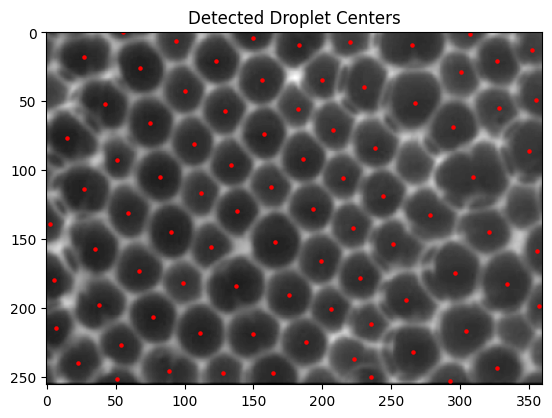

In [2]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('0.3%A.png', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Contrast Enhancement (Histogram Equalization)
equalized_image = cv2.equalizeHist(image)

# Step 2: Apply Manual Thresholding (with dynamic range)
# Experiment with threshold values based on your image contrast
_, thresh = cv2.threshold(equalized_image, 100, 255, cv2.THRESH_BINARY_INV)

# Step 3: Apply Morphological Operations (Opening followed by Closing)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # More elliptical kernel for smoother operation
opened_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

# Step 4: Find Contours instead of using Blob Detector
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Identify Droplet Centroids using Contour Moments
centroids = []
for contour in contours:
    # Calculate the centroid of each contour using moments
    M = cv2.moments(contour)
    if M["m00"] != 0:  # Prevent division by zero
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append([cx, cy])

# Convert centroids to a numpy array for easier plotting
centroids = np.array(centroids)

# Plot Results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Load SEM Image in Grayscale
image = cv2.imread('0.3%A.png', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Adaptive Thresholding for Better Contrast Handling
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Step 2: Morphological Operations to Clean Noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Step 3: Distance Transform for Better Separation of Close Droplets
dist_transform = cv2.distanceTransform(morph, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Step 4: Marker-based Watershed Segmentation to Identify Droplets
num_labels, markers = label(sure_fg)
markers = markers.astype(np.int32)  # Convert to int32 for watershed

# Convert grayscale to color (3-channel) for watershed processing
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.watershed(color_image, markers)

# Step 5: Extract Centroids from Segmented Regions
contours, _ = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
centroids = np.array([[int(cv2.moments(c)["m10"] / cv2.moments(c)["m00"]), 
                        int(cv2.moments(c)["m01"] / cv2.moments(c)["m00"])] 
                       for c in contours if cv2.moments(c)["m00"] > 0])

# Plot Results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()


AttributeError: 'int' object has no attribute 'astype'

## Perform Voronoi Tessellation

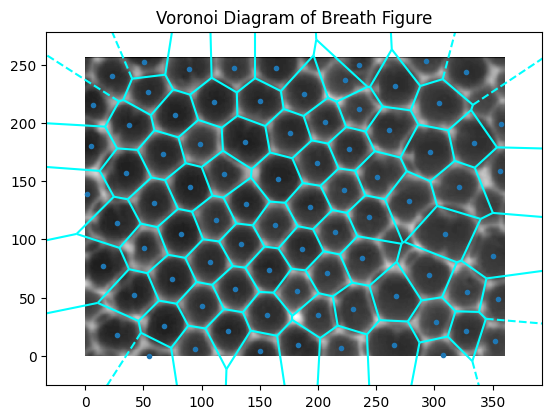

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

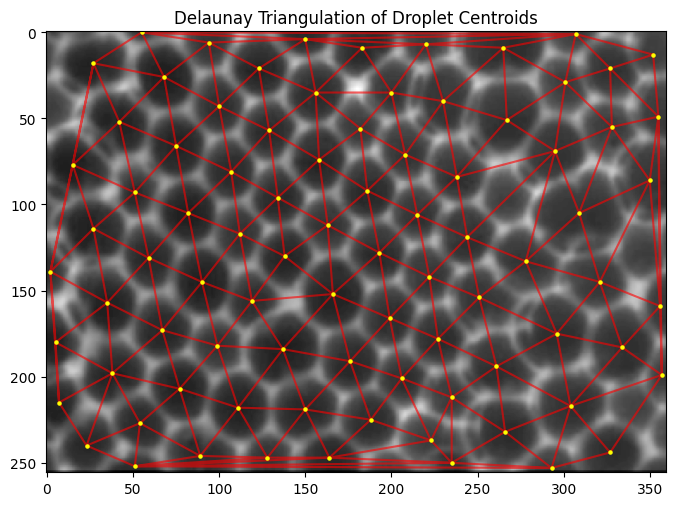

In [4]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

In [49]:
import networkx as nx

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')


Hexagonality Ratio: 0.33
